<a href="https://colab.research.google.com/github/David-Smirnoff/NN_Classif_Hand_Hygiene/blob/main/5_sensores_2D_CNN_Classification_Hand_hygiene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
import os
import json
import seaborn as sns
import tensorflow as tf
%matplotlib widget
warnings.filterwarnings('ignore')

In [ ]:
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from numpy import array
from numpy.linalg import norm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers,layers

In [ ]:

# Specify the path to your JSON file
json_file_path1 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\train.json'
json_file_path2= r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\validation.json'
json_file_path3 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\test.json'

# Open the JSON file and load its contents
#TRAIN
with open(json_file_path1, 'r') as file:
    df_train = json.load(file)
df_train = pd.DataFrame.from_dict(df_train)
df_train = df_train.rename(columns={'event_classifier': 'Class'})
sub_columns_train = pd.DataFrame(df_train['Timestamps'].to_dict()).columns  #Access the sub-column names train

#VALIDATION
with open(json_file_path2, 'r') as file:
    df_validation = json.load(file)
df_validation = pd.DataFrame.from_dict(df_validation)
df_validation = df_validation.rename(columns={'event_classifier': 'Class'})
sub_columns_validation = pd.DataFrame(df_validation['Timestamps'].to_dict()).columns  #Access the sub-column names validation

#TEST
with open(json_file_path3, 'r') as file:
    df_test = json.load(file)
df_test = pd.DataFrame.from_dict(df_test)
df_test = df_test.rename(columns={'event_classifier': 'Class'})
sub_columns_test= pd.DataFrame(df_test['Timestamps'].to_dict()).columns  #Access the sub-column names test

# Concatenate the DataFrames in order
df = pd.concat([df_train, df_validation, df_test])
mean_columns=df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns = pd.DataFrame(df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events

events_quantity=len(df[mean_columns[5]])
points_quantity=len(df['Timestamps'][sub_columns[0]])
sensor_quantity=len(mean_columns)

print(sensor_quantity,points_quantity,events_quantity, mean_columns)


13 60 517 Index(['Timestamps', 'sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]',
       'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]',
       'rh_[%]', 'time_last_event_[s]', '#events_last1h', '#events_last2h',
       'Class'],
      dtype='object')



![separador](https://i.imgur.com/4gX5WFr.png)

# Características:
##### 13 Sensores/// 517 eventos/// Intervalos de tiempo de 300 seg, tomados cada 5 seg (60 features)

![Captura de pantalla 2023-06-09 093808.png](<attachment:Captura de pantalla 2023-06-09 093808.png>)

![separador](https://i.imgur.com/4gX5WFr.png)


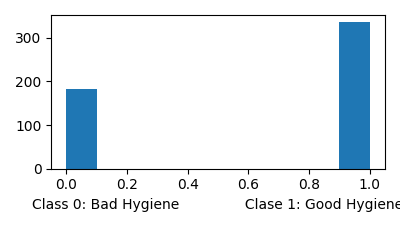

<class 'pandas.core.frame.DataFrame'>
Index: 517 entries, 2018-12-19 10:20:06+01:00 to 2018-12-12 13:28:40+01:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamps           517 non-null    object 
 1   sgp30_EtOH_[au]      517 non-null    object 
 2   sgp30_H2_[au]        517 non-null    object 
 3   tgs8100_R_[Ohms]     517 non-null    object 
 4   tgs2600_R_[Ohms]     517 non-null    object 
 5   ccs811_R_[Ohms]      517 non-null    object 
 6   tag_R_[Ohms]         517 non-null    object 
 7   temp_[C]             517 non-null    object 
 8   rh_[%]               517 non-null    object 
 9   time_last_event_[s]  517 non-null    float64
 10  #events_last1h       517 non-null    int64  
 11  #events_last2h       517 non-null    int64  
 12  Class                517 non-null    int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 72.7+ KB


In [ ]:
plt.figure(figsize=(4,2.27))
plt.hist(df['Class'])  #Bins es el ancho de la columna
plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
plt.tight_layout()
plt.show(); df.info()

![separador](https://i.imgur.com/4gX5WFr.png)

### Aumento Clase 2
![separador](https://i.imgur.com/4gX5WFr.png)


Cada clase tiene elementos: 182 335
Ahora cada clase tiene elementos: 282 335


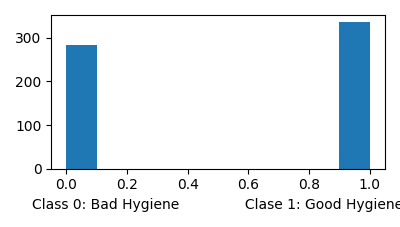

13 60 617 Index(['Timestamps', 'sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]',
       'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]',
       'rh_[%]', 'time_last_event_[s]', '#events_last1h', '#events_last2h',
       'Class'],
      dtype='object')


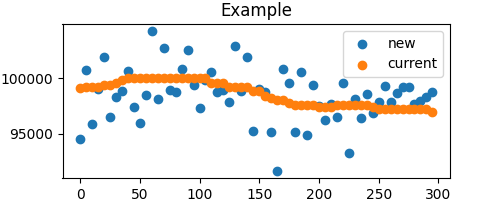

In [ ]:
df_class0 = df[df['Class'] == 0]
df_class1 = df[df['Class'] == 1]
print('Cada clase tiene elementos:',len(df_class0),len(df_class1))
# Numero para balancear la data
selected_sensors=['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]','rh_[%]']
# Creo un DataFrame para almacenar la data balanceada
balanced_df = pd.DataFrame(columns=df.columns)

aumento=100
for buf in range(0,aumento):
    # Copy the row
    new_row = df_class0.sample(n=1)
    current_row=new_row.copy()
    # Add Gaussian noise to selected features
    for sensor in selected_sensors:
        noise=np.random.normal(0,0.025,points_quantity)
        new_row[sensor][0] =[x *(1+ y) for x, y in zip(new_row[sensor][0], noise)]
    if buf==60:
        plt.figure(figsize=(5,2))
        t=np.arange(0, points_quantity * 5, 5)
        for sensor in range(2,3):
            plt.scatter(t,new_row[mean_columns[5]][0],label='new')
            plt.scatter(t,current_row[mean_columns[5]][0],label='current')
            plt.title('Example')
            plt.xlabel('t [s]')
            plt.legend()
    # Append the modified row to the balanced data frame
    balanced_df = balanced_df.append(new_row, ignore_index=True)

# Concatenate the balanced class 2 data frame with the original class 1 data frame
balanced_df = pd.concat([df, balanced_df], axis=0,ignore_index=True)
balanced_df = balanced_df.sample(frac=1)#, random_state=42)  # frac=1 shuffles all rows, random_state for reproducibility

df_class0= balanced_df[balanced_df['Class'] == 0]
df_class1 = balanced_df[balanced_df['Class'] == 1]
mean_columns2=balanced_df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns2 = pd.DataFrame(balanced_df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events
events_quantity=len(balanced_df[mean_columns[5]])
points_quantity=len(balanced_df['Timestamps'][sub_columns2[0]])

print('Ahora cada clase tiene elementos:',len(df_class0) , len(df_class1))
plt.figure(figsize=(4,2.27))
plt.hist(balanced_df['Class'])  #Bins es el ancho de la columna
plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
plt.tight_layout()
plt.show()
print(sensor_quantity,points_quantity,events_quantity, mean_columns)


![separador](https://i.imgur.com/4gX5WFr.png)

# Sensores:

##### Estacionarios: SGP30_EtOH (arbitrary units); SGP30_H2 (a.u.); TGS8100 R (Ω); TGS2600 R (Ω); CCS811 R (Ω)
##### HYT939 Temperature/ humidity  T (◦C) r.h. (%) stationary
##### Portable: TGS8100 R (Ω) tag   <span style="color:red">No me va a importar.</span>
![separador](https://i.imgur.com/4gX5WFr.png)


0

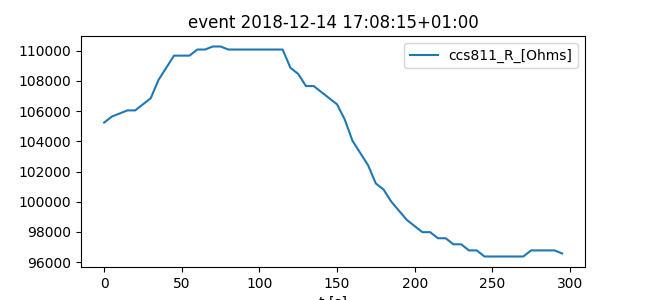

In [ ]:
event=np.arange(0,616,1); t=np.arange(0, points_quantity * 5, 5);   #choose event;
event=604
plt.figure(figsize=(6.5, 3))
for sensor in range(5,6):
    plt.plot(t,balanced_df[mean_columns[sensor]][sub_columns2[event]],label=f'{mean_columns[sensor]}')
plt.title(f'event {balanced_df[mean_columns[0]][sub_columns2[event]][0]}')
plt.xlabel('t [s]')
plt.legend()
balanced_df[mean_columns[12]][event]


![separador](https://i.imgur.com/4gX5WFr.png)

# Prueba 5 Sensores

### Red Convolucional 2D

![separador](https://i.imgur.com/4gX5WFr.png)


##### Defino PlotLoss, PlotAcc, Plot_Conf_Matrix

In [ ]:
def plotLoss(result, extra_title=""):
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

def plotAcc(result, extra_title=""):
    acc = result.history['sparse_categorical_accuracy']
    val_acc = result.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

def plot_conf_matrix(results, X, Y, extra_title=""):
    cm = metrics.confusion_matrix(Y, results)
    print(cm)
    plt.figure(1)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B Hygiene','G Higyene'])
    disp.plot()
    plt.title("Matriz de confusion "+extra_title)
    plt.show()


![separador](https://i.imgur.com/4gX5WFr.png)

### Normalizo data y creo modelo

![separador](https://i.imgur.com/4gX5WFr.png)

In [ ]:
# Resume
selected_sensor = mean_columns[1:6]
selected_sensor = selected_sensor.tolist()
print(selected_sensor)
Y = balanced_df["Class"]
Y = Y.astype(np.int64) # Convertir la variable a un tipo de datos compatible

X = np.zeros((len(balanced_df), len(selected_sensor), 60))  # Inicializar X con ceros
for i, sensor in enumerate(selected_sensor):   #tanto el índice como el elemento actual en cada iteración
    x_curr = balanced_df[sensor]  # Acceder a la columna del sensor actual
    x_curr = pd.DataFrame(x_curr.tolist())
    scaler = StandardScaler().fit(x_curr)
    x_curr = scaler.transform(x_curr)
    #print('xxxxx',x_curr.shape)
    X[:, i, :] = x_curr

print(X.shape,type(X),Y.shape,type(Y))
### SACO DATA PARA UN FINAL TEST
# Convert Y to a numpy array
Y = Y.values
# Set the number of samples to extract
num_samples = 10
# Get the indices of the samples to extract randomly
sample_indices = np.random.choice(X.shape[0], size=num_samples, replace=False)
# Extract the samples and their corresponding labels
final_test_X = X[sample_indices]
final_test_Y = Y[sample_indices]
# Drop the rows from the original X and Y
X = np.delete(X, sample_indices, axis=0)
Y = np.delete(Y, sample_indices)
print(X.shape,type(X),Y.shape,type(Y))
print(final_test_Y)

# Forma Functional API
def creo_modelo(input_shape):
    inputs = keras.Input(shape=input_shape, name="Input_1")
    x = layers.Conv2D(filters=64, kernel_size=(2, 16), strides=(1, 1), activation="relu", name="Conv_1")(inputs)
    x = layers.BatchNormalization(name="BatchNorm_1")(x)     # Batch normalization
    x = layers.AveragePooling2D(pool_size=(2, 2), name="Max_pool_1")(x)  # Pooling
    x = layers.Conv2D(filters=64, kernel_size=(2, 1), strides=(1, 1), activation="relu", name="Conv_2")(x)    #print('aaaaaaa',x)
    x = layers.BatchNormalization(name="BatchNorm_2")(x)   # Batch normalization
    x = layers.AveragePooling2D(pool_size=(1, 1), name="Max_pool_2")(x)   # Pooling

    x = layers.Flatten(name="Flatten_1")(x)
    x = layers.Dense(32, activation="relu", name="Dense_1")(x)
    x = layers.Dropout(0.15)(x)  # Dropout layer
    outputs = layers.Dense(2, activation="softmax", name="Softmax_1")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Modelo_2D_CNN")
    return model

input_shape = (5, 60, 1)
model = creo_modelo(input_shape)
model.summary()

['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]']
(617, 5, 60) <class 'numpy.ndarray'> (617,) <class 'pandas.core.series.Series'>
(607, 5, 60) <class 'numpy.ndarray'> (607,) <class 'numpy.ndarray'>
[1 0 1 0 0 0 0 0 1 0]
Model: "Modelo_2D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_1 (InputLayer)        [(None, 5, 60, 1)]        0         
                                                                 
 Conv_1 (Conv2D)             (None, 4, 45, 64)         2112      
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 4, 45, 64)        256       
 tion)                                                           
                                                                 
 Max_pool_1 (AveragePooling2  (None, 2, 22, 64)        0         
 D)                                                

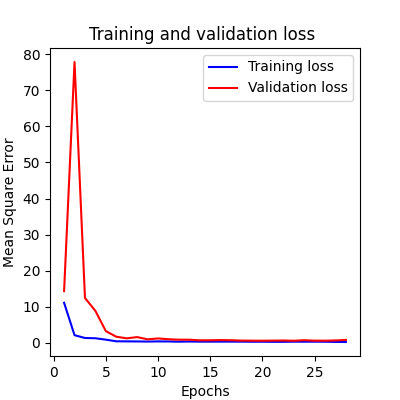

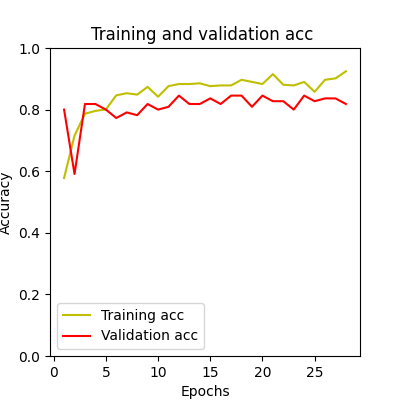

2/2 [==============================] - 0s 7ms/step - loss: 0.3459 - sparse_categorical_accuracy: 0.8852
100 Test accuracy: 0.89
2/2 [==============================] - 0s 7ms/step
[[28  1]
 [ 6 26]]


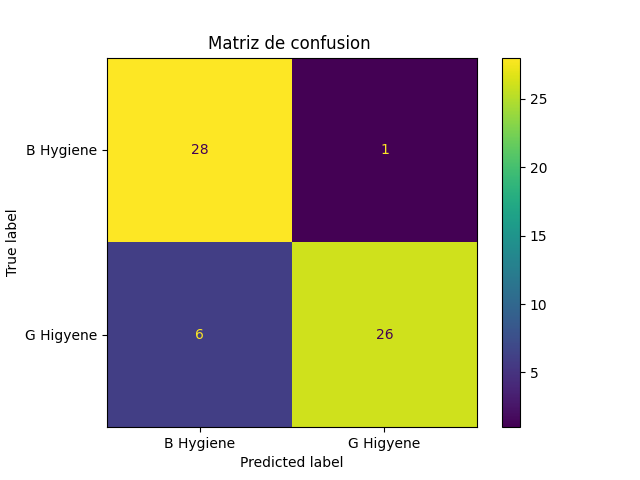

In [ ]:
#def genero_modelo_y_entreno(X, Y, early=False, epochs=60, bs=64, val_frac=0.2, vb=1):
early= True;epochs=60; bs=64; val_frac=0.2;vb=0


#Para HOLD OUT sacar random state
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.1)  ## YA VIENEN NORMALIZADOS

model = creo_modelo(input_shape = (5, 60, 1))
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=opt,
                loss="sparse_categorical_crossentropy",
                metrics=["sparse_categorical_accuracy"])

callbacks = []
if early:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(early_stopping)
else:
    #It monitors the validation loss and reduces the learning rate by a factor of 0.1 if the validation loss does not improve for 5 consecutive epochs.
    #The minimum learning rate is set to 0.0001.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=0.0001);callbacks.append(reduce_lr)


result = model.fit(X_train, Y_train, epochs=epochs, batch_size=bs, validation_split=val_frac, callbacks=callbacks, verbose=vb)

graph = 1
if graph == 1:
    plotLoss(result)
    plotAcc(result)
Accuracy=[]
test_loss, test_acc = model.evaluate(X_test, Y_test)
Accuracy.append(test_acc)
print(buf+1,f"Test accuracy: {test_acc:.2f}")

pred = model.predict(X_test)
res = [np.argmax(num) for num in pred]
plot_conf_matrix(res, X_test, Y_test)



In [ ]:
# Accuracy=[]
# n=1
# for buf in range(0,n):
#     genero_modelo_y_entreno(X,Y, early=True, epochs=60, bs=64, val_frac=0.2,vb=0)

# mean = np.mean(Accuracy)
# std_dev = np.std(Accuracy)
# print(Accuracy)
# print("Mean:", "Standard Deviation:" ,f"{mean*100:.0f}",f"{ std_dev*100:.1f}")
# print(model)

1/1 [==============================] - 0s 92ms/step
Accuracy: 0.9
Confusion Matrix:
[[6 1]
 [0 3]]


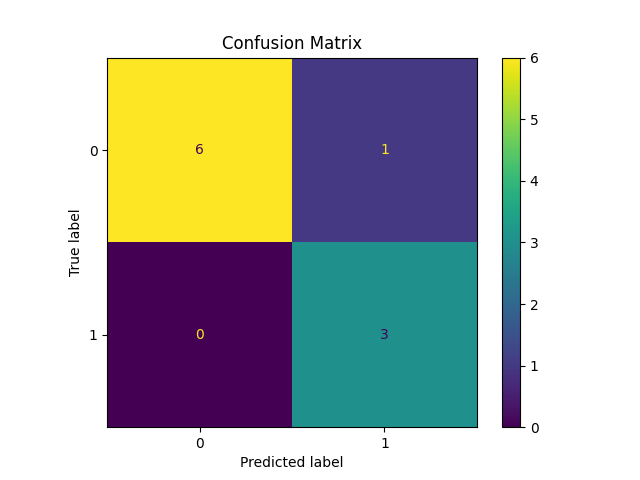

In [ ]:
# Make predictions
predictions = model.predict(final_test_X)

# Apply softmax function to the predictions
threshold = 0.5
predictions = np.where(predictions >= threshold, 1, 0)
pred=np.zeros(10)
for i in range(0,len(predictions)):
    if predictions[i][0]==1: pred[i]=0
    else:  pred[i]=1

cm = confusion_matrix(final_test_Y, pred)
accuracy = accuracy_score(final_test_Y, pred)

print('Accuracy:', accuracy) # Print the accuracy
print('Confusion Matrix:'); print(cm) # Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm); disp.plot(); plt.title("Confusion Matrix"); plt.show() # Visualize the confusion matrix

![separador](https://i.imgur.com/4gX5WFr.png)

# Con K fold
### (Falta aparatar data para el test final)

![separador](https://i.imgur.com/4gX5WFr.png)

In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler

# def genero_modelo2_y_entreno(X, Y, early=False, epochs=60, bs=64, val_frac=0.2, vb=1, n_splits=5):

#     kf = KFold(n_splits=n_splits)
#     Accuracy = []

#     for fold, (train_index, test_index) in enumerate(kf.split(X)):
#         X_train, X_test = X[train_index], X[test_index]
#         Y_train, Y_test = Y[train_index], Y[test_index]

#         # Rest of your code...

#         model = creo_modelo(input_shape=(5, 60, 1))
#         opt = tf.keras.optimizers.Adam(learning_rate=0.05)
#         model.compile(optimizer=opt,
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["sparse_categorical_accuracy"])

#         # ...the rest of your code...
#         callbacks = []
#         if early:
#             early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#             callbacks.append(early_stopping)
#         else:
#         #It monitors the validation loss and reduces the learning rate by a factor of 0.1 if the validation loss does not improve for 5 consecutive epochs.
#         #The minimum learning rate is set to 0.0001.
#             reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=0.0001);callbacks.append(reduce_lr)

#         result = model.fit(X_train, Y_train, epochs=epochs, batch_size=bs, validation_split=val_frac, callbacks=callbacks, verbose=vb)

#         # ...the rest of your code...

#         test_loss, test_acc = model.evaluate(X_test, Y_test)
#         Accuracy.append(test_acc)
#         print(f"Fold {fold+1} Test accuracy: {test_acc:.2f}")

#         pred = model.predict(X_test)
#         res = [np.argmax(num) for num in pred]
#         plot_conf_matrix(res, X_test, Y_test)

#     # Compute and print the average accuracy across all folds
#     average_accuracy = sum(Accuracy) / len(Accuracy)
#     print(f"Average accuracy across {n_splits} folds: {average_accuracy:.2f}")

In [ ]:
# genero_modelo2_y_entreno(X,Y, early=True, epochs=60, bs=64, val_frac=0.2,vb=0, n_splits=10)